In [2]:
!pip install pytesseract


FileUpload(value={}, accept='image/*', description='Upload')

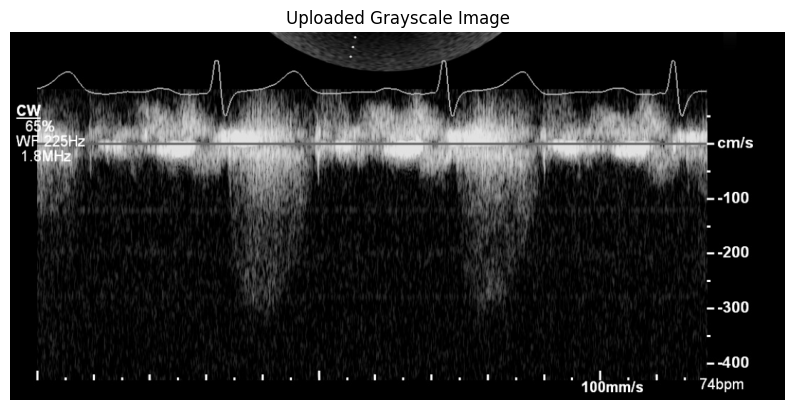

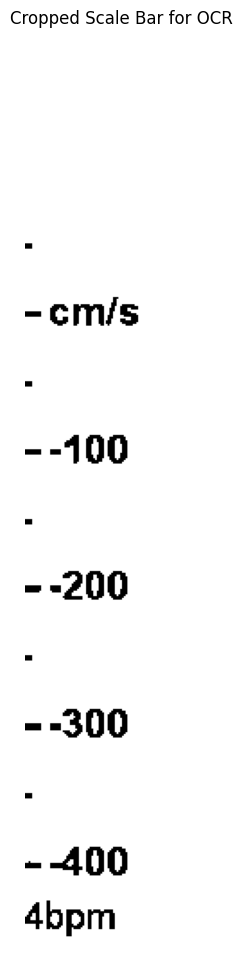


🔍 OCR Detected Text + Positions:
  → 'emis' at pixel (x=1004, y=144)
  → '00' at pixel (x=1023, y=233)
  → '200' at pixel (x=1007, y=297)
  → '300' at pixel (x=1013, y=371)
  → '400' at pixel (x=1013, y=448)
  → '4bpm' at pixel (x=1003, y=495)


In [3]:
from IPython.display import display
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract
from PIL import Image
import io

# Upload widget
upload = widgets.FileUpload(accept='image/*', multiple=False)
display(upload)

def process_uploaded_image(change):
    # --- Load uploaded image ---
    uploaded_file = list(upload.value.values())[0]
    content = uploaded_file['content']
    np_arr = np.frombuffer(content, np.uint8)
    image = cv2.imdecode(np_arr, cv2.IMREAD_GRAYSCALE)

    # --- Display original image ---
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title("Uploaded Grayscale Image")
    plt.axis('off')
    plt.show()

    # --- Crop rightmost 10% (assumed vertical scale bar) ---
    h, w = image.shape
    crop_width = int(w * 0.1)
    scale_bar = image[:, w - crop_width:]

    # --- Preprocess for OCR ---
    eq = cv2.equalizeHist(scale_bar)
    _, thresh = cv2.threshold(eq, 160, 255, cv2.THRESH_BINARY)
    inverted = cv2.bitwise_not(thresh)

    # --- Show cropped + processed image ---
    plt.figure(figsize=(4, 12))
    plt.imshow(inverted, cmap='gray')
    plt.title("Cropped Scale Bar for OCR")
    plt.axis('off')
    plt.show()

    # --- OCR: extract any readable text ---
    # ⬇️ Config: use --psm 6 (assumes text in blocks), allow all common chars
    custom_config = r'--psm 6 -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ/+-μ%.'

    d = pytesseract.image_to_data(inverted, config=custom_config, output_type=pytesseract.Output.DICT)

    # --- Extract ALL detected text (numbers AND units) + positions ---
    results = []
    for i in range(len(d['text'])):
        text = d['text'][i].strip()
        if text:
            x, y, w_box, h_box = d['left'][i], d['top'][i], d['width'][i], d['height'][i]
            cx, cy = x + w_box // 2, y + h_box // 2
            # Adjust x to full image context
            results.append((text, (cx + (w - crop_width), cy)))

    # --- Sort by y for vertical scale bars ---
    results = sorted(results, key=lambda x: x[1][1])

    # --- Display results ---
    print("\n🔍 OCR Detected Text + Positions:")
    for text, (cx, cy) in results:
        print(f"  → '{text}' at pixel (x={cx}, y={cy})")

# Hook up the handler
upload.observe(process_uploaded_image, names='value')
